## Packages

In [2]:
import pandas as pd
import numpy as np
import os
import glob
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn import manifold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import statsmodels.api as sm
from matplotlib import offsetbox
from time import time

#os.chdir('C:\\Users\\A Sua\\Documents\\FIU\\CAP2020')
os.chdir('C:\\Users\\Daniel\\Python and R Notebooks\\CAP2020\\CAP2020')

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


## Define Functions

In [3]:
folder = "C:\\Users\\Daniel\\Python and R Notebooks\\CAP2020\\CAP2020\\data\\processed"
final_data = "data\\processed\\compiled_quarterly_final_v2.csv"

In [4]:
#print computation time script
def timing(f):
    def wrap(*args):
        time1 = time()
        ret = f(*args)
        time2 = time()
        print('{:s} function took {:.3f} ms'.format(f.__name__, (time2-time1)*1000.0))

        return ret
    return wrap

In [5]:
def duplicated_varnames(df):
    """Return a dict of all variable names that 
    are duplicated in a given dataframe."""
    repeat_dict = {}
    var_list = list(df) # list of varnames as strings
    for varname in var_list:
        # make a list of all instances of that varname
        test_list = [v for v in var_list if v == varname] 
        # if more than one instance, report duplications in repeat_dict
        if len(test_list) > 1: 
            repeat_dict[varname] = len(test_list)
    return repeat_dict

In [73]:
def plot_embedding(X, y, title=None, xlabel=None, ylabel=None):
    x_min, x_max = np.min(X, 0)-5, np.max(X, 0)+5
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)
    if xlabel is not None:
        plt.xlabel(xlabel)
    if ylabel is not None:
        plt.ylabel(ylabel)
    plt.show()
        
def new_embedding(X, title=None, xlabel=None, ylabel=None):
    x_min, x_max = np.min(X, 0)-5, np.max(X, 0)+5
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    ax = plt.subplot(111)
    
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)
    if xlabel is not None:
        plt.xlabel(xlabel)
    if ylabel is not None:
        plt.ylabel(ylabel)
    plt.show()
    
def colorize_kmeans(data, num_clusters, step_size, num_iter=10, title=None):
    reduced_data = data
    kmeans = KMeans(init='k-means++', n_clusters=num_clusters, n_init=num_iter) ## 3 clusters run with 
    kmeans.fit(reduced_data)
    
    # Step size of the mesh. Decrease to increase the quality of the VQ.
    h = step_size    # point in the mesh [x_min, x_max]x[y_min, y_max].

    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = reduced_data[:, 0].min() - 5., reduced_data[:, 0].max() + 5.
    y_min, y_max = reduced_data[:, 1].min() - 5., reduced_data[:, 1].max() + 5.
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    # Obtain labels for each point in mesh. Use last trained model.
    Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(1)
    plt.clf()
    plt.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=plt.cm.Paired,
               aspect='auto', origin='lower')

    plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
    # Plot the centroids as a white X
    centroids = kmeans.cluster_centers_
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker = 'x',
                #marker=[str(centroids[i]) for i in range(len(centroids))], 
                s=75, linewidths=3,
                color='w', zorder=10)
    ## plot cluster numbers
    centroid_num_list = [str(i) for i in range(num_clusters)]
    for value, marker in enumerate(centroid_num_list):
        plt.text(kmeans.cluster_centers_[value, 0]+.03, kmeans.cluster_centers_[value, 1]+.01, s = marker, 
                 fontdict= {'family' : 'normal', 'weight' : 'bold','size': 22}, c='w')
    
    #plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
              #'Centroids are marked with white cross')
    plt.title(title)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    #plt.xticks(())
    #plt.yticks(())
    plt.show()
    return kmeans     

## Import Data

In [7]:
df2 = pd.read_csv(final_data)
print('initial shape {}'.format(df2.shape))
df2.head()

initial shape (62252, 11)


,Quarter end,Shares split adjusted,Price,EPS basic,EPS diluted,Dividend per share,Dividend payout ratio,P/E ratio,Long-term debt to equity ratio,Symbol,Quarter
0,9/30/2019,67151778,63.99,0.59,0.58,0.035,0.0488,21.69,0.1859,AAN,2019Q3
1,6/30/2019,67547497,57.23,0.63,0.62,0.035,0.0464,19.94,0.1880,AAN,2019Q2
2,3/31/2019,67677449,48.63,0.83,0.82,0.035,0.0459,17.49,0.2251,AAN,2019Q1
3,12/31/2018,67202919,47.00,0.90,0.89,0.040,0.0455,10.83,0.1937,AAN,2018Q4
4,9/30/2018,68594784,48.86,0.64,0.62,0.030,0.0267,12.00,0.1686,AAN,2018Q3


### D/E ratio - make dataframe

In [8]:
de_ratio = df2[['Quarter', 'Symbol', 'Long-term debt to equity ratio']]
de_ratio = de_ratio.iloc[::-1]
de_ratio.head()

,Quarter,Symbol,Long-term debt to equity ratio
62251,2013Q1,ZTS,5.1340
62250,2013Q2,ZTS,4.5500
62249,2013Q3,ZTS,4.3203
62248,2013Q4,ZTS,3.8745
62247,2014Q1,ZTS,3.3816


In [9]:
# initiate variables for concatenation

stock_list = de_ratio.Symbol.unique()
columns = list(de_ratio.Quarter.unique())
columns.sort()
de_final = pd.DataFrame(columns = columns)

In [10]:
# Look for duplicate quarters to fix

for stock in stock_list:
    df = de_ratio[de_ratio['Symbol']==stock]
    df = df[['Quarter', 'Long-term debt to equity ratio']]
    df.set_index('Quarter', inplace = True)
    
    df = df.T
    
    as_list = df.index.tolist()
    idx = as_list.index('Long-term debt to equity ratio')
    as_list[idx] = stock
    df.index = as_list
    
    print(stock, duplicated_varnames(df))

ZTS {}
ZMH {}
ZION {}
YUM {}
YHOO {}
X {}
XYL {}
XTO {}
XRX {}
XRAY {}
XOM {}
XL {}
XLNX {}
XEL {}
XEC {}
WY {}
WYN {}
WYNN {}
WYE {}
WWY {}
WU {}
WRK {}
WPX {}
WPO {}
WPI {}
WM {}
WM_old {}
WMT {}
WMB {}
WLTW {}
WLP {}
WIN {}
WINA {}
WHR {}
WFT {}
WFR {}
WFMI {}
WFC {}
WEN {}
WEC {}
WDR {}
WDC {}
WB {}
WBA {}
WAT {}
WAG {}
V {}
VZ {}
VTR {}
VRTX {}
VRSN {}
VRSK {}
VNO {}
VMC {}
VLO {}
VIVO {}
VIA.B {}
VFC {}
VAR {}
UTX {}
UST {}
USB {}
URI {}
URBN {}
UPS {}
UNP {}
UNM {}
UNH {}
ULTA {}
UIS {}
UHS {}
UG {}
UDR {}
UA {}
UAL {}
T {}
TYC {}
TXT {}
TXN {}
TWX {}
TWTR {}
TWC {}
TT {}
TSS {}
TSO {}
TSN {}
TSLA {}
TSCO {}
TRV {}
TROW {}
TRIP {}
TMO {}
TMK {}
TLAB {}
TKR {}
TJX {}
TIN {}
TIF {}
TIE {}
THC {}
TGT {}
TE {}
TEX {}
TER {}
TEL {}
TEG {}
TDG {}
TDC {}
TAP {}
S {}
SYY {}
SYNT {}
SYMC {}
SYK {}
SYF {}
SWY {}
SWN {}
SWK {}
SWKS {}
SVU {}
SUN {}
STZ {}
STX {}
STT {}
STR {}
STJ {}
STI {}
SSP {}
SRE {}
SRCL {}
SPLS {}
SPG {}
SO {}
SOV {}
SNPS {}
SNI {}
SNDK {}
SNA {}
SLM {}
SLG {}
SLE {}


In [18]:
for stock in stock_list:
    df = de_ratio[de_ratio['Symbol']==stock]
    df = df[['Quarter', 'Long-term debt to equity ratio']]
    df.set_index('Quarter', inplace = True)
    
    df = df.T
    
    as_list = df.index.tolist()
    idx = as_list.index('Long-term debt to equity ratio')
    as_list[idx] = stock
    df.index = as_list
    
    de_final = pd.concat([de_final, df], sort = True)

In [19]:
de_final

,1993Q2,1993Q3,1993Q4,1994Q1,1994Q2,1994Q3,1994Q4,1995Q1,1995Q2,1995Q3,...,2017Q3,2017Q4,2018Q1,2018Q2,2018Q3,2018Q4,2019Q1,2019Q2,2019Q3,2019Q4
ZTS,0.0,0.0,0.000,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,2.4897,2.7983,2.5276,2.5152,3.0411,2.9487,2.8390,0.0000,0.0000,0.0
ZMH,0.0,0.0,0.000,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.8804,0.7599,0.7907,0.7816,0.7037,0.7465,0.7205,0.0000,0.0000,0.0
ZION,0.0,0.0,0.000,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0534,0.0540,0.0543,0.0544,0.1258,0.1033,0.1749,0.0000,0.0000,0.0
YUM,0.0,0.0,0.000,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0
YHOO,0.0,0.0,0.000,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ABBV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0806,6.0728,8.6986,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AA,NaN,NaN,0.406,0.458,0.3581,0.3057,0.2611,0.2593,0.2479,0.3304,...,1.1543,1.4019,1.2102,1.2259,1.1902,1.0685,1.1542,1.2296,NaN,NaN
AAP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.3231,0.3058,0.2946,0.2857,0.2857,0.2945,0.2105,NaN,NaN,NaN
AAPL,NaN,NaN,0.000,NaN,0.1358,0.1278,0.1187,0.1120,0.1071,0.1044,...,0.7252,0.7412,0.7989,0.8450,0.8748,0.7888,0.8521,0.8806,1.0146,NaN


## Exploring PCA and t-SNE

In [20]:
de_final.fillna(0, inplace=True)

### PCA-100

In [26]:
pca100 = PCA(n_components=100)
pca100.fit(de_final)
print(sum(pca100.explained_variance_ratio_))

0.9999991288583893


### PCA-50

In [27]:
pca50 = PCA(n_components=50)
pca50.fit(de_final)
print(sum(pca50.explained_variance_ratio_))

0.999125024793426


### PCA-25

In [29]:
pca25 = PCA(n_components=25)
pca25.fit(de_final)
print(sum(pca25.explained_variance_ratio_))

0.9910791358247434


### PCA-10

In [30]:
pca10 = PCA(n_components=10)
pca10.fit(de_final)
print(sum(pca10.explained_variance_ratio_))

0.9465457168497767


In [31]:
de_pca = pca25.fit_transform(de_final)

### t-SNE pseudo-Grid search

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


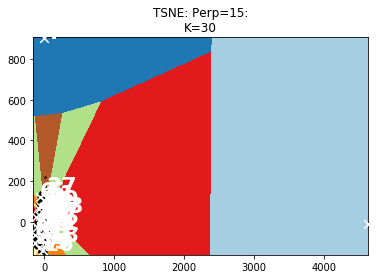

In [74]:
df_copy = de_pca
step = 0.5
perp = 20
k_value = 30
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0, perplexity=perp, learning_rate=50)
t0 = time()
X_all_tsne = tsne.fit_transform(de_pca)
kmeans = colorize_kmeans(data=X_all_tsne, num_clusters=k_value, step_size=step, num_iter=10, title='TSNE: Perp={}:\nK={}'.format(i, k_value))

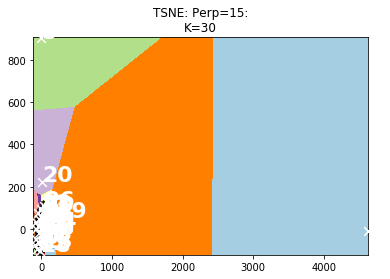

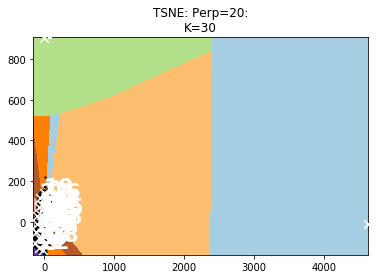

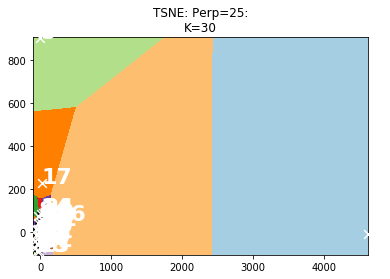

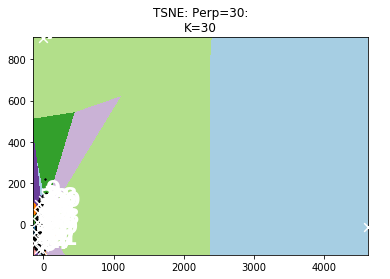

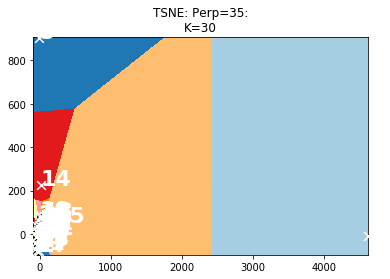

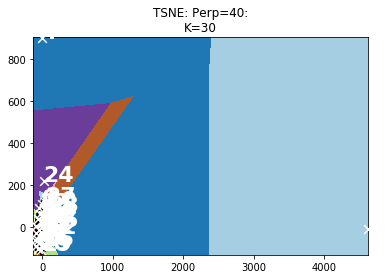

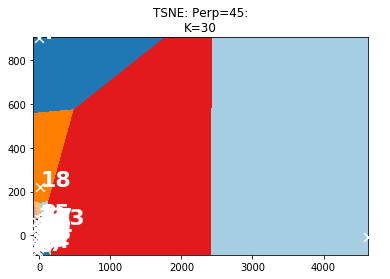

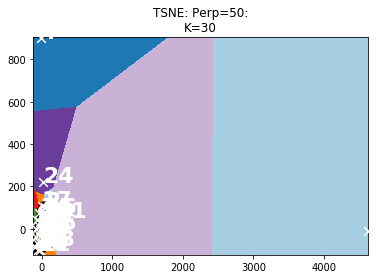

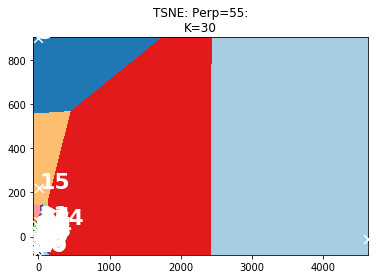

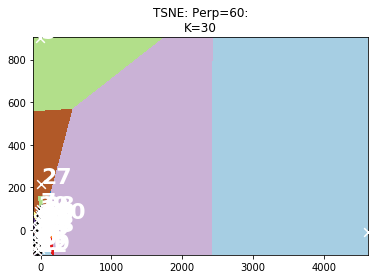

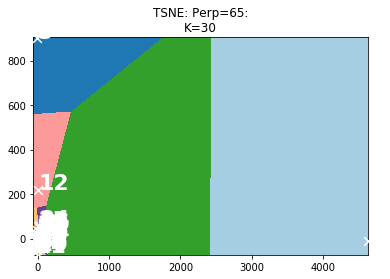

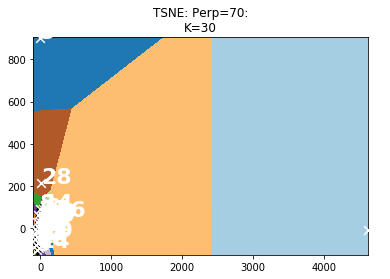

In [77]:
k_value = 30
step = 0.5
dic_of_top_stocks = {}
for i in range(15,75,5):
    df_copy = de_pca
    perp = i
    tsne = manifold.TSNE(n_components=2, init='pca', random_state=0, perplexity=perp, learning_rate=50)
    t0 = time()
    X_all_tsne = tsne.fit_transform(de_pca)
    kmeans = colorize_kmeans(data=X_all_tsne, num_clusters=k_value, step_size=step, num_iter=10, title='TSNE: Perp={}:\nK={}'.format(i, k_value))

In [ ]:
k_value = 25
dic_of_top_stocks = {}
for i in range(15,75,5):
    df_copy = df09_18.iloc[:, 2:].copy()
    perp = i
    tsne = manifold.TSNE(n_components=2, init='pca', random_state=0, perplexity=perp, learning_rate=50)
    t0 = time()
    X_all_tsne = tsne.fit_transform(X09_18)
    plot_embedding(X=X_all_tsne, y=y_all, title='All Years tSNE Mapping: Perplexity = {}'.format(perp))
    
    """BEGIN KMEANS"""
    print('begin kmenans')
    kmeans = colorize_kmeans(data=X_all_tsne, num_clusters=k_value, num_iter=10, title='TSNE: Perp={}:\nK={}'.format(i, k_value))
    #labels = pd.Series(kmeans.labels_)
    df_copy['cluster_labels'] = kmeans.labels_
    """LISTS OF THE MEANS RETURNS OF EVERY CLUSTER VALUE"""
    cluster_means_k = []
    cluster_vars_k = []

    for cluster_index in range(k_value):
        """FILTER BY CLUSTER VALUE"""
        temp_df = df_copy[df_copy['cluster_labels']==cluster_index].T.iloc[2:-1, :]
        stock_symbols = temp_df.columns
        """TEMP CLUSTER MEANS AND VARIANCES ACCROSS STOCKS"""
        cluster_means = []
        cluster_vars = []
        for symbol in stock_symbols:
            """FOR EVERY STOCK, TAKE THE AVERAGE RETURN AND AVERAGE VARIANCE"""
            
            temp_series = temp_df[[symbol]]
            temp_mean   = temp_series.mean()
            temp_var = temp_series.var()
            cluster_means.append(temp_mean[0])
            cluster_vars.append(temp_var[0])
            """ONCE THE AVERAGE RETURN AND AVERERAGE VARIANCE IS COMPUTED ACCROSS ALL STOCKS, APPEND TO THE EMPTY LISTS ABOVE"""    
        cluster_means_k.append(np.mean(cluster_means))
        cluster_vars_k.append(np.mean(cluster_vars))
        #print('cluster means appended')
    
    clusterk_means_num = []
    for cluster, mean in enumerate(cluster_means_k):
        """FOR EVERY ENUMERAATED CLUSTER APPEND THE CLUSTER VALUE AND MEAN RETURN AND SORT BY THAT"""
        #print(cluster, mean)
        clusterk_means_num.append((cluster, mean))
    ### sort the list
    clusterk_means_num.sort(key=lambda x: x[1], reverse=True) 
        
    ### pick index     
    index_best_cluster = clusterk_means_num[0][0]
    print('The best cluster was cluster {}'.format(index_best_cluster))
    
    best_df = df_copy[df_copy['cluster_labels']==index_best_cluster].T.iloc[2:-1, :]
    print('best df has shape {}'.format(best_df.shape))
    """merge the df whose cluster index has the highest avg return"""
    reduced_df_final = pd.merge(best_df.T.iloc[:, 0], df19, how='inner', on=None, left_on=None, right_on=None,
             left_index=True, right_index=True, sort=True,
             suffixes=('_x', '_y'), copy=True, indicator=False).T.iloc[3:, :]

    reduced_df_final.index = pd.to_datetime(reduced_df_final.index, format='%d/%b/%Y', infer_datetime_format=True)
    print('reduce df final has shape {}'.format(reduced_df_final.shape))
    ########
    ###########--------Merge with the price DF-------------#########
    #######
    prices = pd.merge(reduced_df_final.iloc[0, :].T, df_close19.T, how='inner', on=None, left_on=None, right_on=None,
             left_index=True, right_index=True, sort=True,
             suffixes=('_x', '_y'), copy=False, indicator=False).T.iloc[1:, ]
    print(prices.shape)
    returns = prices.apply(lambda x: total_return(x), axis=0)
    print('Cluster {} had a total return of {} in the first 3 quarters of 2019'.format(index_best_cluster, np.mean(returns)))
    
    
    """append dictionary... with the stock symbols that belonged to the cluster"""
    stocks_per_top_cluster = tuple(prices.columns)
    dic_of_top_stocks['k{}_perp{}'.format(k_value, perp)] = stocks_per_top_cluster
    #list_of_top_stocks.append(stocks_per_top_cluster)
    """what is the set of all clusters belonging to the top clusters?"""
    
    


    """plot the company returns of best average cluster"""
    sp_return = 0.20177154127199878
    plt.hist(returns, bins=10)
    plt.axvline(x=0., color='red')
    plt.axvline(x=sp_return, color='yellow')
    plt.axvline(x=np.mean(returns), color='black')
    plt.xlim(-0.8, 0.8)
    plt.title('Total Returns: Best Portfolio where K={}\n1/1/19-9/30/19'.format(k_value))
    #plt.savefig('Best_Portfolio3_2pca.png')
    plt.show()
